In [1]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

# Load Data

In [6]:
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
train_transforms = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
	transforms.ToTensor(), 
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transforms = transforms.Compose([
	transforms.ToTensor(), 
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_data = CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

BATCH_SIZE = 64
NUM_WORKERS = 4

# Dataloaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

classes = ['plane', 'car', 'bird', 'cat', 
		   'deer', 'dog', 'frog', 'horse', 'ship', 
		   'truck']

Files already downloaded and verified
Files already downloaded and verified


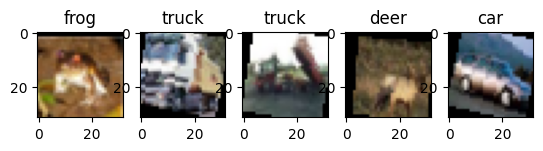

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize some images
fig = plt.figure()
for i in range(5):
	img = train_loader.dataset[i][0]
	img = img.numpy()
	img = np.transpose(img, (1, 2, 0))
	# unnormalize
	img = img * 0.5 + 0.5
	ax = fig.add_subplot(1, 5, i+1)
	ax.imshow(img)
	ax.set_title(classes[train_loader.dataset[i][1]])

In [24]:
# Create Model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        
        self.classifier = nn.Sequential(
            # Fully Connected layers
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.features.forward(x)
        x = x.view(-1, 256 * 4 * 4)  # Flatten the tensor
        x = self.classifier.forward(x)
        return x
	
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [16]:
from tqdm import tqdm

def train(epoch, loss_vals):
	running_loss = 0.0
	model.train()
	loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch}")
	for data, target in loop:
		data, target = data.to(device), target.to(device)
		results = model(data) # Forward pass
		optimizer.zero_grad() # Clear gradients
		loss = loss_fn(results, target) # Calculate loss
		loss.backward() # Backward pass
		optimizer.step() # Update weights
		running_loss += loss.item()
		loop.set_postfix(loss=loss.item())

	loss_vals.append(running_loss / len(train_loader))

def test(loss_vals):
	running_loss = 0.0
	model.eval()
	with torch.inference_mode():
		for data, target in test_loader:
			data, target = data.to(device), target.to(device)
			results = model(data)
			loss = loss_fn(results, target)
			running_loss += loss.item()
			
		loss_vals.append(running_loss / len(test_loader))

In [17]:
train_loss_vals = []
test_loss_vals = []

In [18]:
EPOCHS = 15
for epoch in range(EPOCHS):
	train(epoch, train_loss_vals)
	test(test_loss_vals)

In [19]:
train_loss_vals, test_loss_vals

([1.9727628755447504,
  1.6096360555390263,
  1.4276158465143969,
  1.30098497943805,
  1.2024162817184272,
  1.1186286873372315,
  1.0613401392689141,
  1.005204211872862,
  0.9579518989986165,
  0.9129078779226679,
  0.8747171282463366,
  0.8406727253399846,
  0.8105644109989981,
  0.7833346082350178,
  0.7601485104512071],
 [1.5642241118060556,
  1.3668399008975667,
  1.1923573449918419,
  1.0862550731677159,
  1.0431781395985062,
  0.9471122903429019,
  0.8826118092628041,
  0.8480674047378978,
  0.8041129000247664,
  0.7866378870739299,
  0.7346056764292869,
  0.71378822349439,
  0.7271786983225755,
  0.6638682444763792,
  0.6602545879828702])

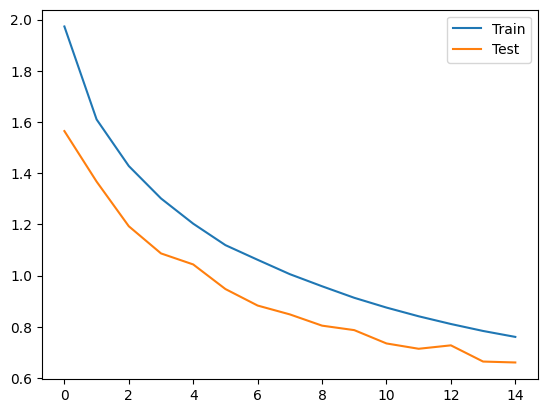

In [20]:
# Plot loss curve]

plt.figure()
plt.plot(range(EPOCHS), train_loss_vals, label='Train')
plt.plot(range(EPOCHS), test_loss_vals, label='Test')
plt.legend()
plt.show()

In [21]:
from pathlib import Path

# Save model
model_path = Path("./models")
model_path.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), "models/model.pth")

In [22]:
correct = 0
total = 0
with torch.inference_mode():
	for data, target in test_loader:
		data, target = data.to(device), target.to(device)
		results = model(data)
		# Check for correct predictions
		for i in range(len(target)):
			if torch.argmax(results[i]) == target[i]:
				correct += 1
			total += 1

print(
	f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 77 %
